# Ch.9 Advanced deep learning for computer vision


**Chapter contents**:

* 컴퓨터 비전의 다양한 분야: **이미지 분류(classificaation), 이미지 분할(segmentation), 물체 감지(detection)**

* 최신 convnet 아키텍처 패턴: **residual connections, batch normalization, depthwise separable convolutions**

* convnet 이 **학습한 내용을 시각화**하고 해석하는 기술

## Three essential computer vision tasks

* **이미지 분류(classification)**
    * 이미지에 하나 이상의 레이블 지정
    

* **이미지 분할(segmentation)**
    * 이미지를 서로 다른 영역으로 분할합니다. 각 영역은 일반적으로 범주(category)를 나타냅니다.
    

* **물체 감지(detection)**
    * 이미지에서 관심 있는 개체 주위에 사각형(경계 상자(bounding boxes))을 그리고 각 사각형을 클래스와 연결합니다.


* 기타 작업
    * 이미지 유사도 점수(image similarity scoring)
    * 키포인트 감지
    * 포즈 추정
    * 3D 메쉬(mesh) 추정
    * ...
  
  <img src="https://drek4537l1klr.cloudfront.net/chollet2/Figures/09-01.png" width="500"><p style="text-align:center">Figure 9.1 The three main computer vision tasks: classification, segmentation, detection</p>

## An image segmentation example

이미지 분할의 두 가지 유형:

* **의미론적 세분화(Semantic segmentation)**: 각 픽셀은 "고양이"와 같은 의미론적 범주로 독립적으로 분류됩니다. 고양이가 두 마리인 경우 둘 다 "고양이" 범주에 매핑됩니다.


* **인스턴스 분할(Instance segmentation)**: 개별 개체 인스턴스도 구분합니다(예: "cat1", "cat2", ...).

<img src="https://drek4537l1klr.cloudfront.net/chollet2/Figures/09-02.png" width="500"><p style="text-align:center"> Figure 9.2 Semantic segmentation vs. instance segmentation</p>

의미론적 분할(semantic segmentation)의 예를 보겠습니다.

**Oxford-IIIT Pets 데이터셋**(세그멘테이션 마스크가 있는 고양이와 강아지 사진 7,390장)을 사용합니다.

마스크 값:

1. 전경(foreground)
2. 배경(background)
3. 윤곽(contour)

In [ ]:
!curl -O https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!curl -O https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

In [8]:
import os

input_dir = "images/"
target_dir = "annotations/trimaps/"

input_img_paths = sorted(
    [os.path.join(input_dir, fname)
     for fname in os.listdir(input_dir)
     if fname.endswith(".jpg")])
target_paths = sorted(
    [os.path.join(target_dir, fname)
     for fname in os.listdir(target_dir)
     if fname.endswith(".png") and not fname.startswith(".")])

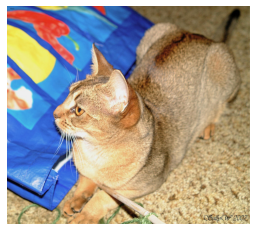

In [9]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

plt.axis("off")
plt.imshow(load_img(input_img_paths[9]))

[1. 2. 3.]


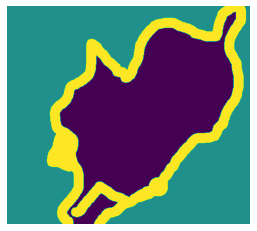

In [10]:
import numpy as np

def display_target(target_array):
    normalized_array = (target_array.astype("uint8") - 1) * 127
    plt.axis("off")
    plt.imshow(normalized_array[:, :, 0])

img = img_to_array(load_img(target_paths[9], color_mode="grayscale"))
print(np.unique(img))
display_target(img)

In [11]:
import numpy as np
import random

img_size = (200, 200)
num_imgs = len(input_img_paths)

random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_paths)

def path_to_input_image(path):
    return img_to_array(load_img(path, target_size=img_size))

def path_to_target(path):
    img = img_to_array(
        load_img(path, target_size=img_size, color_mode="grayscale"))
    img = img.astype("uint8") - 1
    return img

input_imgs = np.zeros((num_imgs,) + img_size + (3,), dtype="float32")
targets    = np.zeros((num_imgs,) + img_size + (1,), dtype="uint8")
for i in range(num_imgs):
    input_imgs[i] = path_to_input_image(input_img_paths[i])
    targets[i]    = path_to_target(target_paths[i])

num_val_samples = 1000
train_input_imgs = input_imgs[:-num_val_samples]
train_targets    = targets[:-num_val_samples]
val_input_imgs   = input_imgs[-num_val_samples:]
val_targets      = targets[-num_val_samples:]

In [18]:
from tensorflow import keras
from tensorflow.keras import layers

def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))
    x = layers.Rescaling(1./255)(inputs)

    x = layers.Conv2D( 64, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2D( 64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(256, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)

    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose( 64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose( 64, 3, activation="relu", padding="same", strides=2)(x)

    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    model = keras.Model(inputs, outputs)
    return model

model = get_model(img_size=img_size, num_classes=3)
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 rescaling_3 (Rescaling)     (None, 200, 200, 3)       0         
                                                                 
 conv2d_19 (Conv2D)          (None, 100, 100, 64)      1792      
                                                                 
 conv2d_20 (Conv2D)          (None, 100, 100, 64)      36928     
                                                                 
 conv2d_21 (Conv2D)          (None, 50, 50, 128)       73856     
                                                                 
 conv2d_22 (Conv2D)          (None, 50, 50, 128)       147584    
                                                                 
 conv2d_23 (Conv2D)          (None, 25, 25, 256)       2951

Exampler of Conv2DTranspose:

* input shape: 100,100,64
* Conv2D(128, 3, strides=2, padding="same")
* output shape: 50,50,128
* input shape: 50,50,128
* Conv2DTranspose(64, 3, strides=2, padding="same")
* output shape: 100,100,64

In [ ]:
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.keras",
                                    save_best_only=True)
]

history = model.fit(train_input_imgs, train_targets,
                    epochs=50,
                    callbacks=callbacks,
                    batch_size=2,
                    validation_data=(val_input_imgs, val_targets))

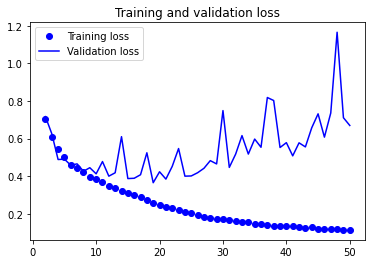

In [9]:
epochs = range(1, len(history.history["loss"]) + 1)
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.figure()
plt.plot(epochs[1:], loss[1:], "bo", label="Training loss")
plt.plot(epochs[1:], val_loss[1:], "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

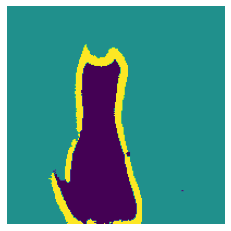

In [8]:
from tensorflow.keras.utils import array_to_img

model = keras.models.load_model("oxford_segmentation.keras")

i = 4
test_image = val_input_imgs[i]
plt.axis("off")
plt.imshow(array_to_img(test_image))

mask = model.predict(np.expand_dims(test_image, 0))[0]

def display_mask(pred):
    mask = np.argmax(pred, axis=-1)
    mask *= 127
    plt.axis("off")
    plt.imshow(mask)

display_mask(mask)

###  Modern convnet architecture patterns

모델의 "아키텍처(architecture)": 그것을 만드는 데 들어간 선택의 총합
* 사용할 레이어들
* 구성하는 방법
* 어떤 배열로 연결

이러한 선택은 모델의 가설 공간(hypothesis space)(기울기 하강법이 검색할 수 있는 가능한 함수의 공간, 모델의 가중치로 매개변수화됨)을 정의합니다.

사전 지식(prior knowledge) 인코딩

예: 컨볼루션 레이어 $\rightarrow$ 입력 이미지에 있는 관련 패턴은 변환 불변(translation-invariant)입니다.

### Modularity, hierarchy, and reuse

<img src="https://drek4537l1klr.cloudfront.net/chollet2/Figures/09-07.png" width="500"><p style="text-align:center">Figure 9.7 Complex systems follow a hierarchical structure and are organized into distinct modules, which are reused multiple times (such as your four limbs, which are all variants of the same blueprint, or your 20 “fingers”).</p>

주요 아이디어: 블록/모듈(blocks/modules)로 모델 구조화

e.g. VGG: "conv,conv,max pooling"

특징 계층(피라미드-유사 구조)

e.g. Conv filters: 32,64,128, ...?

<img src="https://drek4537l1klr.cloudfront.net/chollet2/Figures/09-08.png" width="500"><p style="text-align:center">Figure 9.8 The VGG16 architecture: note the repeated layer blocks and the pyramid-like structure of the feature maps</p>

### Residual connections

Game of Telephone: 잡음이 있는 채널을 통한 순차적 전송에서 발생하는 누적 오류

`y = f4(f3(f2(f1(x))))`

함수 체인이 너무 깊으면 잡음이 그래디언트 정보를 압도하기 시작합니다.

역전파가 작동을 멈춥니다

모델이 전혀 훈련되지 않습니다.

이것은 그라디언트 소실(vanishing gradients) 문제입니다.

솔루션: 체인의 각 함수를 비파괴적으로 강제 실행

이전 입력에 포함된 정보의 무소음 버전을 유지

Residual connection

<img src="https://drek4537l1klr.cloudfront.net/chollet2/Figures/09-09.png" width="200"><p style="text-align:center">Figure 9.9 A residual connection around a processing block</p>

Pseudocode
```
x = ...
residual = x
x = block(x)
x = add([x, residual])
```
If output shape != input shape: use 1x1 Conv2D with no activation..

**Residual block where the number of filters changes**

In [20]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(32, 32, 3))
x = layers.Conv2D(32, 3, activation="relu")(inputs)
residual = x
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
residual = layers.Conv2D(64, 1)(residual)
x = layers.add([x, residual])

**Case where target block includes a max pooling layer**

In [21]:
inputs = keras.Input(shape=(32, 32, 3))
x = layers.Conv2D(32, 3, activation="relu")(inputs)
residual = x
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
x = layers.MaxPooling2D(2, padding="same")(x)
residual = layers.Conv2D(64, 1, strides=2)(residual)
x = layers.add([x, residual])

In [22]:
inputs = keras.Input(shape=(32, 32, 3))
x = layers.Rescaling(1./255)(inputs)

def residual_block(x, filters, pooling=False):
    residual = x
    x = layers.Conv2D(filters, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(filters, 3, activation="relu", padding="same")(x)
    if pooling:
        x = layers.MaxPooling2D(2, padding="same")(x)
        residual = layers.Conv2D(filters, 1, strides=2)(residual)
    elif filters != residual.shape[-1]:
        residual = layers.Conv2D(filters, 1)(residual)
    x = layers.add([x, residual])
    return x

x = residual_block(x, filters=32, pooling=True)
x = residual_block(x, filters=64, pooling=True)
x = residual_block(x, filters=128, pooling=False)

x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 rescaling_4 (Rescaling)        (None, 32, 32, 3)    0           ['input_7[0][0]']                
                                                                                                  
 conv2d_32 (Conv2D)             (None, 32, 32, 32)   896         ['rescaling_4[0][0]']            
                                                                                                  
 conv2d_33 (Conv2D)             (None, 32, 32, 32)   9248        ['conv2d_32[0][0]']              
                                                                                            

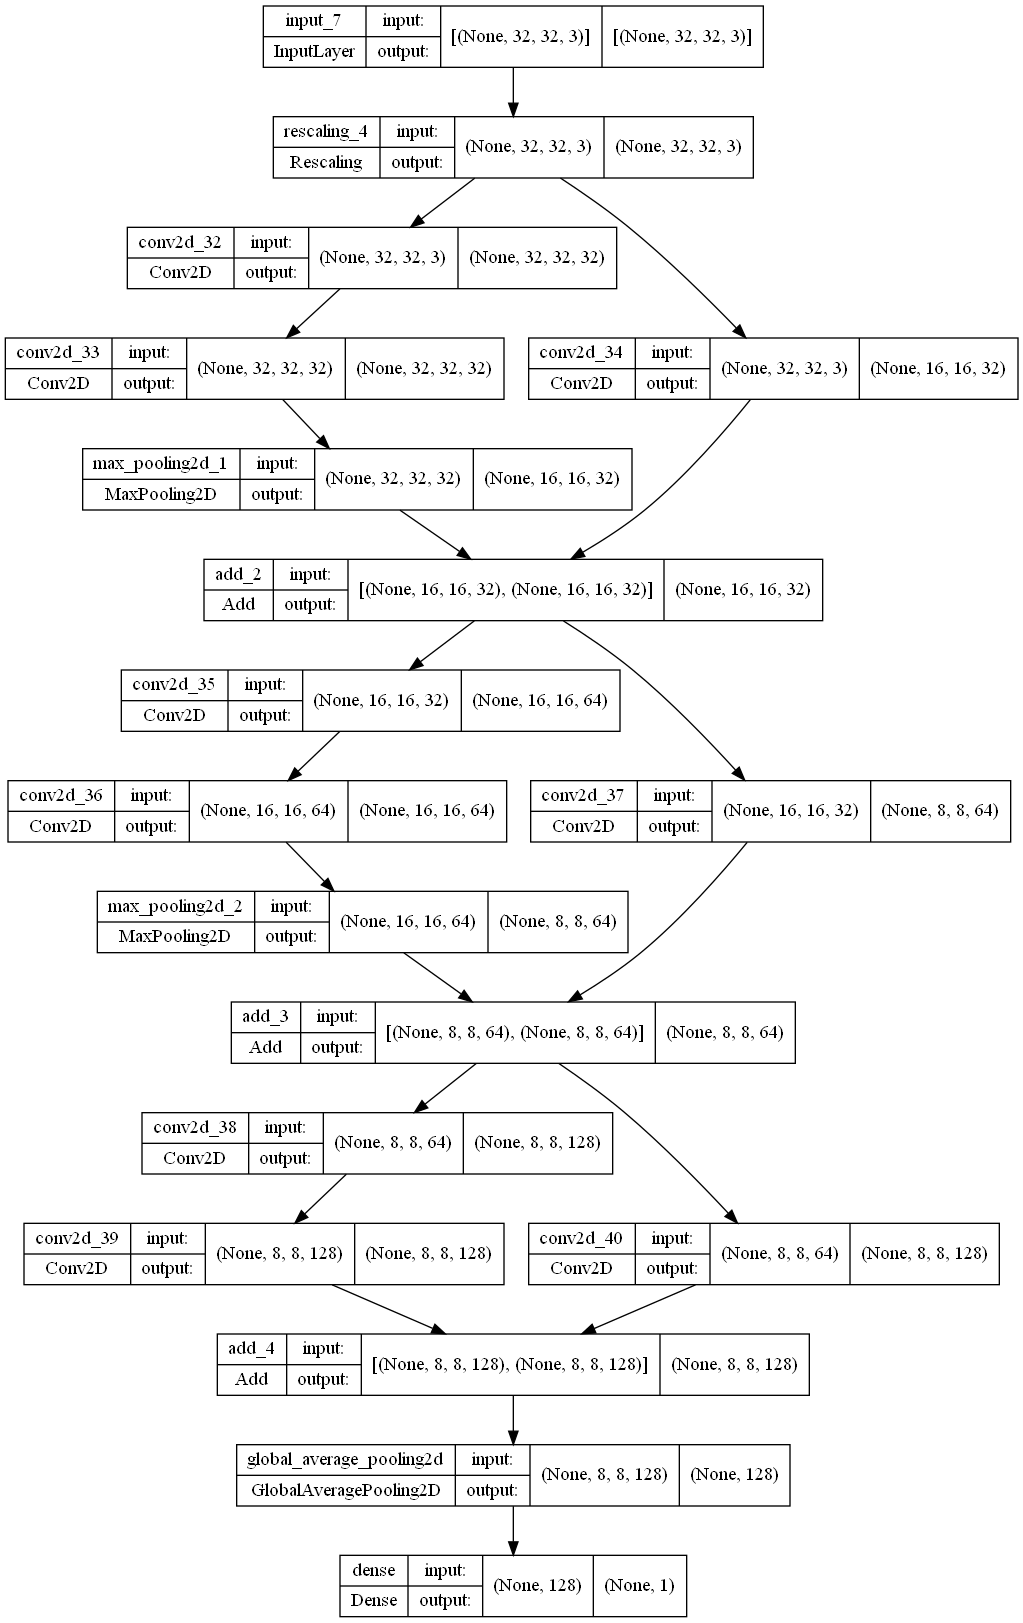

In [23]:
keras.utils.plot_model(model, 'res_model.png', show_shapes=True)

### Batch normalization

더 큰 모델이 더 쉽게 훈련하도록 돕는 또 다른 방법

일반적으로 데이터를 모델에 제공하기 전에 데이터를 정규화합니다(mean=0, std=1).

`normalized_data = (data - np.mean(data,axis=...))/np.std(data,axis=...)`

배치 정규화(Batch normalization)는 이전 레이어의 활성화에 대해 동일한 작업을 수행합니다.

이렇게 하면 활성화가 너무 크거나 너무 작지 않게 됩니다.

이것은 (residual connections과 같은) 그래디언트 전파를 돕습니다 $\rightarrow$ 더 깊은 네트워크를 허용합니다

```
x = ...
x = layers.Conv2D(32, 3, use_bias=False)(x)  # BM make values centered to zeros, 
x = layers.BatchNormalization()(x)           # so bias doesn't do anything..
x = layers.Activation("relu")(x)             # activation after(?) BN
```

### Depthwise separable convolutions

`SeparableConv2D`: Conv2D의 더 가벼운(더 적은 수의 훈련 가능한 가중치 매개변수 및 부동 소수점 연산) 버전

pointwise 컨볼루션(1x1 컨볼루션)을 통해 출력 채널을 혼합하기 전에 입력의 각 채널에 대해 독립적으로 공간 컨볼루션을 수행합니다.

Convolution 가정: 이미지의 패턴은 특정 위치에 연결되어 있지 않습니다.

Depthwise separable convolution 가정: 중간 활성화의 공간 위치는 높은 상관 관계가 있지만 서로 다른 채널들은 매우 독립적입니다.

<img src="https://drek4537l1klr.cloudfront.net/chollet2/Figures/09-10.png" width="400"><p style="text-align:center">Figure 9.10 Depthwise separable convolution: a depthwise convolution followed by a pointwise convolution</p>

### Putting it together: A mini Xception-like model

* 모델을 반복되는 레이어 블록으로 구성
* #_of_filters ↑ 공간 특징 맵의 #_of_size ↓
* 넓고 얕은 것보다 깊고 좁은 것이 낫다
* residula connection은 더 깊은 모델을 훈련하는 데 도움이 됩니다.
* Conv 블록 후에 Batch Normalization 추가
* Conv2D를 SeparableConv2D로 교체


In [ ]:
from google.colab import files
files.upload()

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c dogs-vs-cats
!unzip -qq train.zip

In [ ]:
import os, shutil, pathlib
from tensorflow.keras.utils import image_dataset_from_directory

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

In [24]:
import os, shutil, pathlib
from tensorflow.keras.utils import image_dataset_from_directory

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [25]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

In [26]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)

x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=5, use_bias=False)(x)

for size in [32, 64, 128, 256, 512]:
    residual = x

    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    residual = layers.Conv2D(
        size, 1, strides=2, padding="same", use_bias=False)(residual)
    x = layers.add([x, residual])

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [27]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset)

Epoch 1/100
63/63 [==============================] - 25s 341ms/step - loss: 0.7069 - accuracy: 0.5735 - val_loss: 0.6934 - val_accuracy: 0.5000
Epoch 2/100
63/63 [==============================] - 21s 327ms/step - loss: 0.6552 - accuracy: 0.6160 - val_loss: 0.6968 - val_accuracy: 0.5000
Epoch 3/100
63/63 [==============================] - 21s 336ms/step - loss: 0.6531 - accuracy: 0.6230 - val_loss: 0.7183 - val_accuracy: 0.5000
Epoch 4/100
63/63 [==============================] - 21s 326ms/step - loss: 0.6274 - accuracy: 0.6570 - val_loss: 0.7180 - val_accuracy: 0.5000
Epoch 5/100
63/63 [==============================] - 21s 338ms/step - loss: 0.6084 - accuracy: 0.6595 - val_loss: 0.8661 - val_accuracy: 0.5000
Epoch 6/100
63/63 [==============================] - 21s 337ms/step - loss: 0.5947 - accuracy: 0.6905 - val_loss: 0.8630 - val_accuracy: 0.5000
Epoch 7/100
63/63 [==============================] - 22s 341ms/step - loss: 0.5717 - accuracy: 0.7025 - val_loss: 0.7948 - val_accuracy:

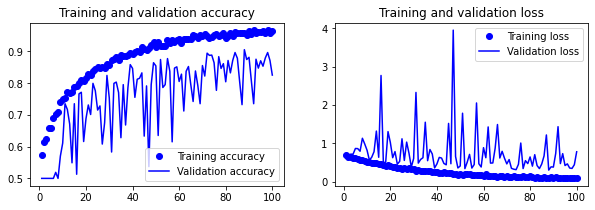

In [30]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.figure(figsize=(10, 3))
plt.subplot(1,2,1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.subplot(1,2,2)
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

<img src="https://drek4537l1klr.cloudfront.net/chollet2/Figures/09-11.png" width="500"><p style="text-align:center">Figure 9.11 Training and validation metrics with an Xception-like architecture</p>

새로운 모델은 90.8%의 테스트 정확도를 달성합니다.

지난 장의 순진한 모델의 경우 83.5%에 비해

아키텍처 모범 사례를 따르면 모델 성능에 즉각적이고 상당한 영향을 미칩니다.

###  Interpreting what convnets learn

컴퓨터 비젼 응용 프로그램에서는 해석 가능성이 중요합니다.

e.g. 모델이 트럭의 이미지를 냉장고로 분류할 수 있습니다. 왜요?

인간의 전문 지식을 보완할 때 특히 중요합니다(예: 의료 영상)

제시된 세 가지 기술(한 가지만 살펴보겠습니다)

* 중간 convnet 출력 시각화
* convnet 필터 시각화
* **이미지에서 클래스 활성화의 히트맵(heatmaps) 시각화**

### Visualizing intermediate activations

**중간 활성화를 시각화**하는 것은 특정 입력이 주어지면 모델의 다양한 컨볼루션 및 풀링 계층에서 반환된 값을 표시하는 것으로 구성됩니다. 이것은 입력이 네트워크에 의해 학습된 여러 필터로 어떻게 분해되는지에 대한 보기를 제공합니다. 너비, 높이, 깊이(채널)의 세 가지 차원으로 특징 맵을 시각화 합니다.

In [ ]:
# You can use this to load the file "convnet_from_scratch_with_augmentation.keras"
# you obtained in the last chapter.
from google.colab import files
files.upload()

In [10]:
from tensorflow import keras
model = keras.models.load_model("convnet_from_scratch_with_augmentation.keras")
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_11 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 87, 87, 64)        18496     
                                                           

**Preprocessing a single image**

In [11]:
from tensorflow import keras
import numpy as np

img_path = keras.utils.get_file(
    fname="cat.jpg",
    origin="https://img-datasets.s3.amazonaws.com/cat.jpg")

def get_img_array(img_path, target_size):
    img = keras.utils.load_img(
        img_path, target_size=target_size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

img_tensor = get_img_array(img_path, target_size=(180, 180))

**Displaying the test picture**

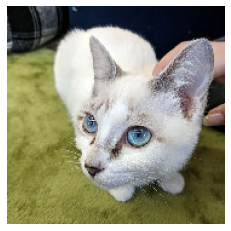

In [12]:
import matplotlib.pyplot as plt
plt.axis("off")
plt.imshow(img_tensor[0].astype("uint8"))
plt.show()

<img src="https://drek4537l1klr.cloudfront.net/chollet2/Figures/09-12.png" width="250"><p style="text-align:center">Figure 9.12 The test cat picture</p>

**Instantiating a model that returns layer activations**

이미지 입력이 제공되면 아래의 모델은 원래 모델의 레이어 활성화 값을 목록으로 반환합니다. 지금까지 본 모델에는 정확히 하나의 입력과 하나의 출력이 있었습니다. 이것은 하나의 입력과 9개의 출력(레이어 활성화당 하나의 출력)을 가지고 있습니다.

In [13]:
from tensorflow.keras import layers

layer_outputs = []    # list for all channels' output
layer_names = []
for layer in model.layers:
    if isinstance(layer, (layers.Conv2D, layers.MaxPooling2D)):    
        layer_outputs.append(layer.output)
        layer_names.append(layer.name)
activation_model = keras.Model(inputs=model.input, outputs=layer_outputs)

**Using the model to compute layer activations**

In [14]:
activations = activation_model.predict(img_tensor)
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 178, 178, 32)


**Visualizing the fifth channel**

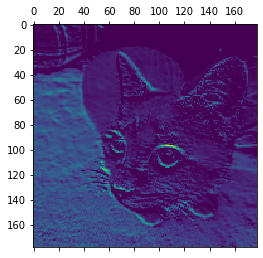

In [21]:
import matplotlib.pyplot as plt
plt.matshow(first_layer_activation[0, :, :, 1], cmap="viridis")

<img src="https://drek4537l1klr.cloudfront.net/chollet2/Figures/09-13.png" width="250"><p style="text-align:center">Figure 9.13 Fifth channel of the activation of the first layer on the test cat picture</p>

**Visualizing every channel in every intermediate activation**

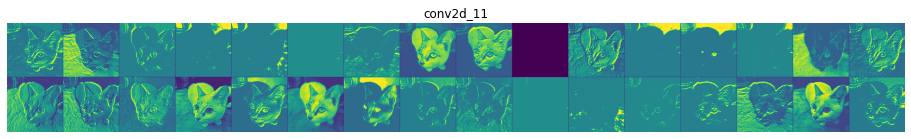

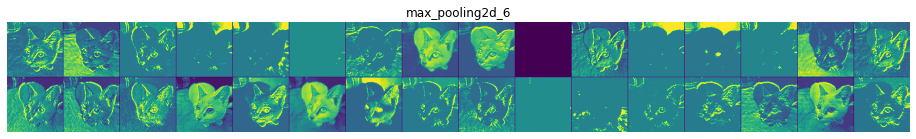

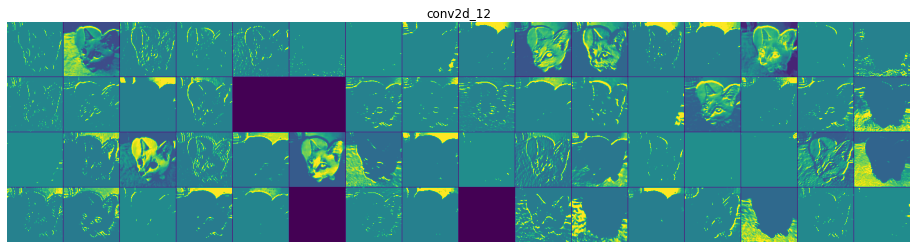

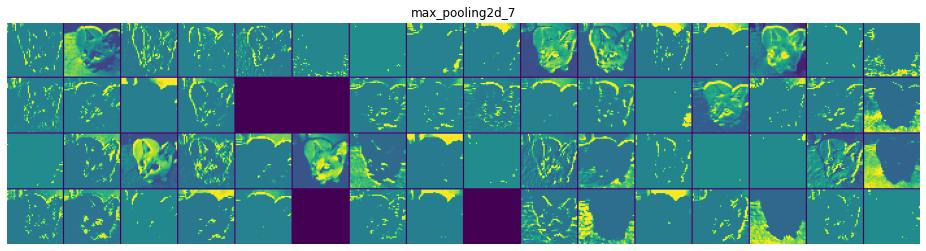

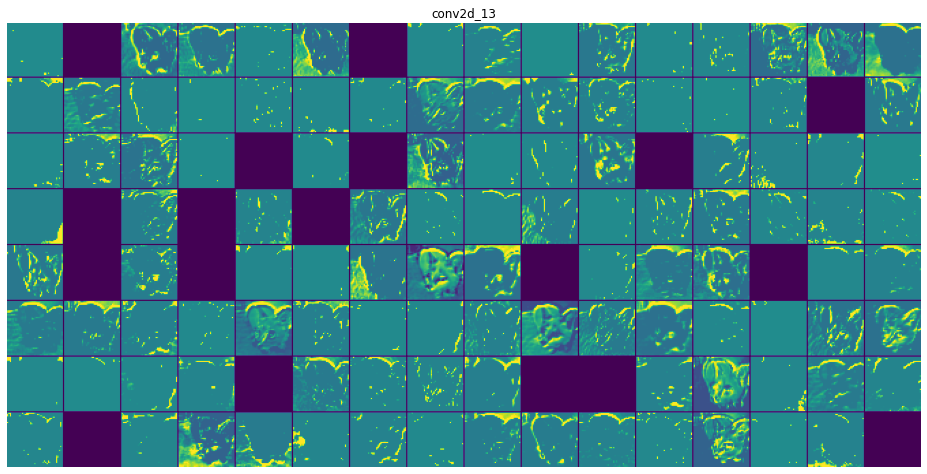

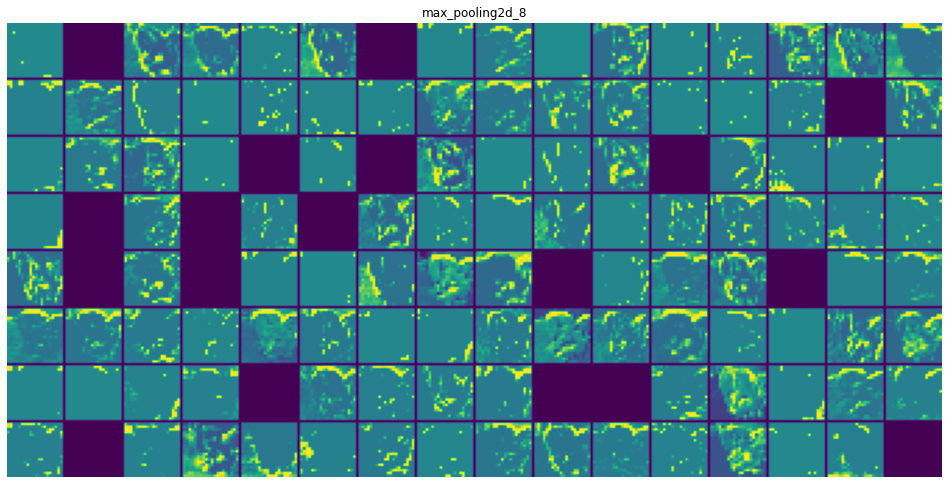

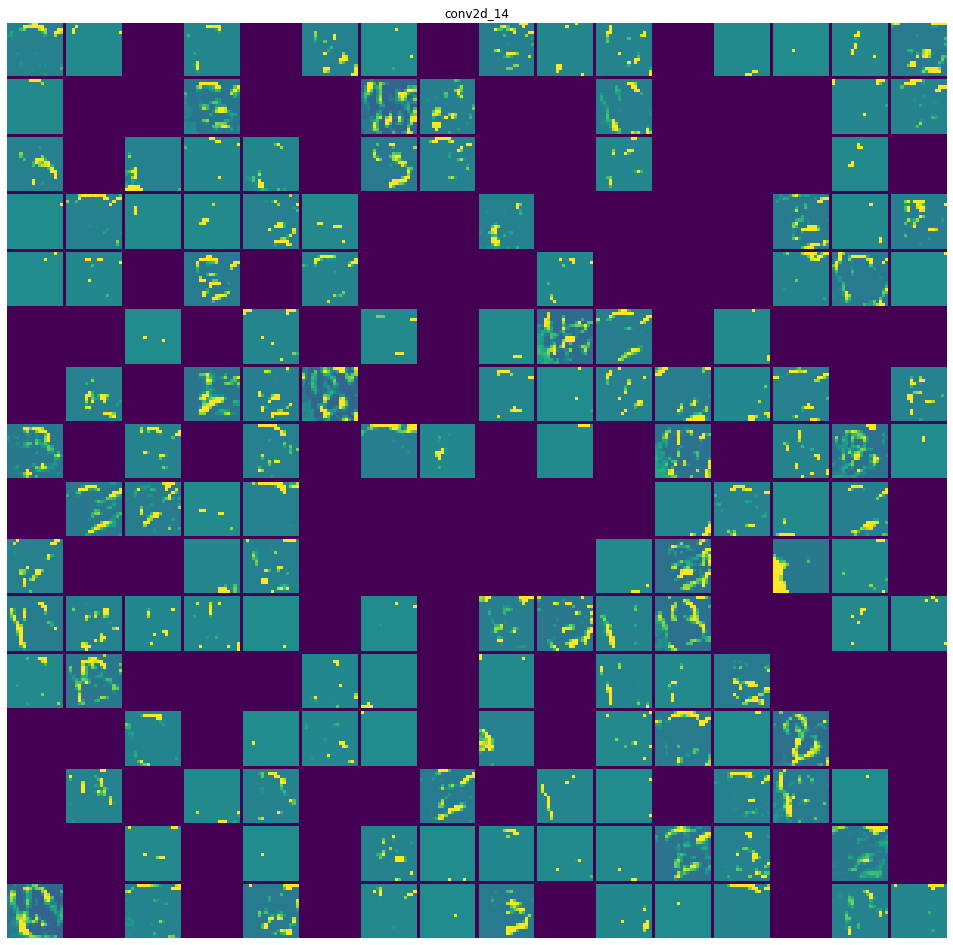

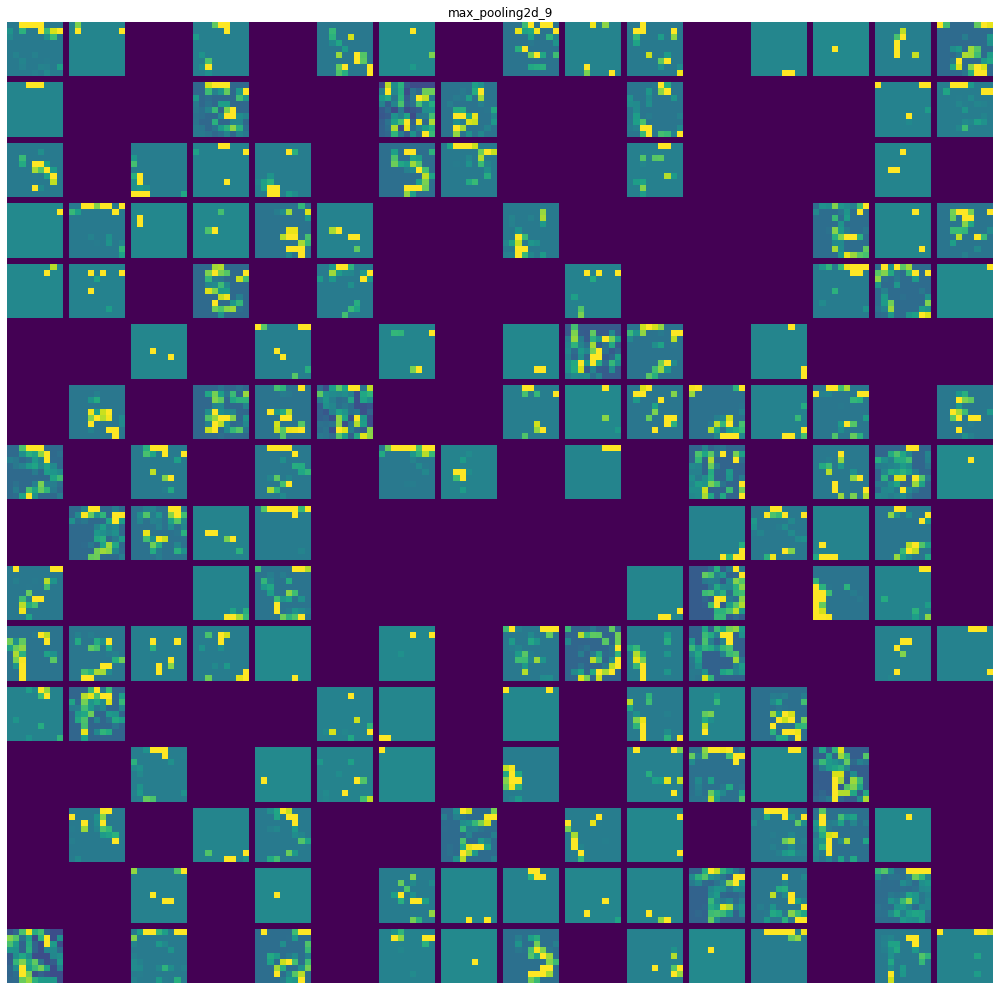

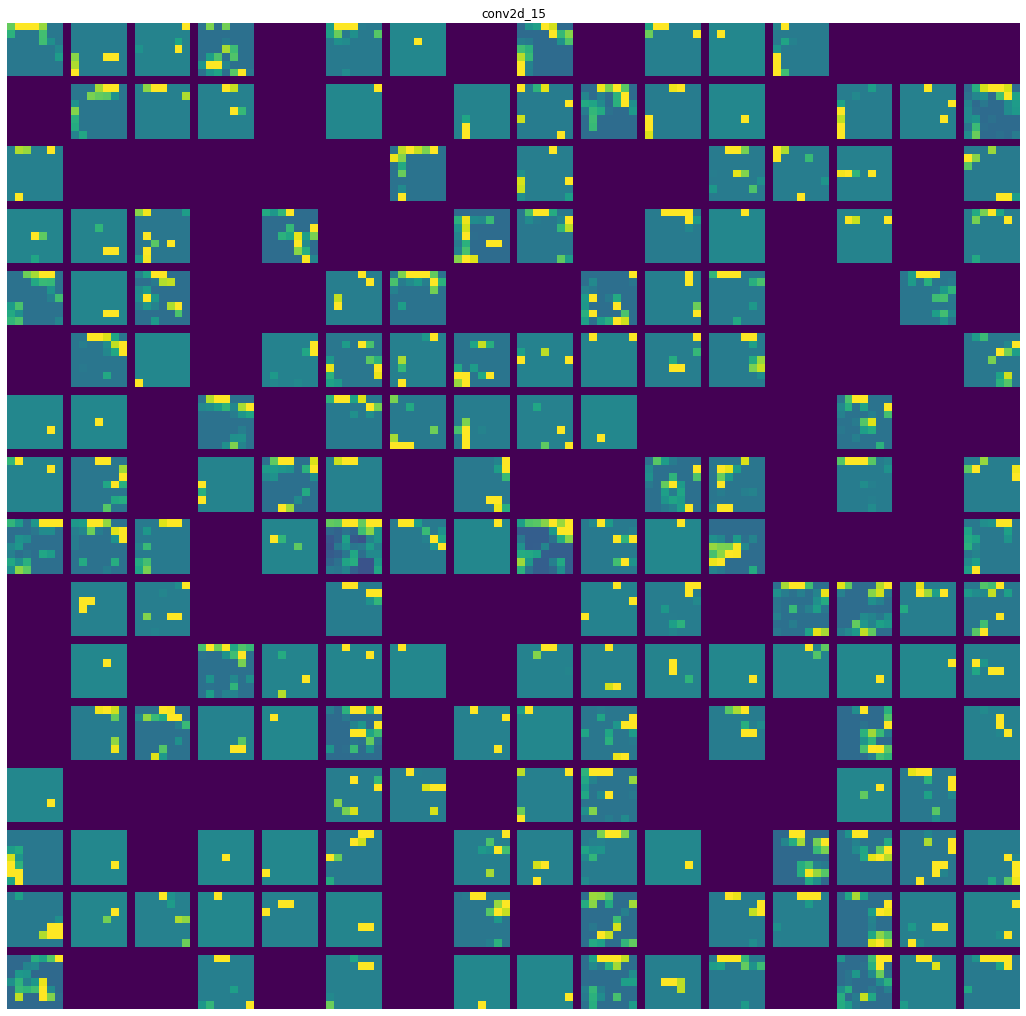

In [22]:
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features // images_per_row
    display_grid = np.zeros(((size + 1) * n_cols - 1,
                             images_per_row * (size + 1) - 1))
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_index = col * images_per_row + row
            channel_image = layer_activation[0, :, :, channel_index].copy()
            if channel_image.sum() != 0:
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype("uint8")
            display_grid[
                col * (size + 1): (col + 1) * size + col,
                row * (size + 1) : (row + 1) * size + row] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.axis("off")
    plt.imshow(display_grid, aspect="auto", cmap="viridis")

<img src="https://drek4537l1klr.cloudfront.net/chollet2/Figures/09-14.png" width="500"><p style="text-align:center">Figure 9.14 Every channel of every layer activation on the test cat picture</p>

Note :
* 첫 번째 레이어는 다양한 에지 감지기의 집합체 역할을 합니다. 이 단계에서 활성화는 초기 그림에 있는 거의 모든 정보를 유지합니다.


* 더 깊이 들어갈수록 활성화는 점점 추상화되고 시각적으로 이해하기 어려워집니다. 그들은 "고양이 귀" 및 "고양이 눈"과 같은 더 높은 수준의 개념을 인코딩하기 시작합니다. 더 깊은 프리젠테이션은 이미지의 시각적 내용에 대한 정보를 점점 더 적게 전달하고 이미지의 클래스와 관련된 정보를 점점 더 많이 전달합니다.


* 활성화의 희소성(sparsity)은 계층의 깊이에 따라 증가합니다. 첫 번째 계층에서는 거의 모든 필터가 입력 이미지에 의해 활성화되지만 다음 계층에서는 점점 더 많은 필터가 비어 있습니다. 이것은 필터에 의해 인코딩된 패턴이 입력 이미지에서 발견되지 않는다는 것을 의미합니다.


<img src="https://drek4537l1klr.cloudfront.net/chollet2/Figures/09-15.png" width="500"><p style="text-align:center">Figure 9.15 Left: attempts to draw a bicycle from memory. Right: what a schematic bicycle should look like.</p>

### Visualizing convnet filters

convnet이 학습한 필터를 검사하는 또 다른 쉬운 방법은 **각 필터가 응답해야 하는 시각적 패턴을 표시**하는 것입니다. 이것은 입력 공간에서 경사 상승(gradient ascent)으로 수행할 수 있습니다. **빈 입력 이미지에서 시작하여 특정 필터의 응답을 최대화하기 위해 convnet의 입력 이미지 값에 경사 상승을 적용**합니다. 결과 입력 이미지는 선택한 필터가 최대로 반응하는 이미지가 됩니다.


* "전체 회색"(즉, 시각적으로 자연스러운)에 가까운 임의의 이미지에서 시작합니다.
* 특정 필터의 출력이 최대화 되도록 기울기 상승 함수를 반복적으로 적용
* 결과 입력 이미지를 정규화하고, 가운데 자르고, [0, 255] 범위로 제한하여 표시 가능한 형식으로 다시 변환합니다.

**Instantiating the Xception convolutional base**

In [33]:
model = keras.applications.xception.Xception(
    weights="imagenet",
    include_top=False)

**Printing the names of all convolutional layers in Xception**

In [34]:
for layer in model.layers:
    if isinstance(layer, (keras.layers.Conv2D, keras.layers.SeparableConv2D)):
        print(layer.name)

block1_conv1
block1_conv2
block2_sepconv1
block2_sepconv2
conv2d_4
block3_sepconv1
block3_sepconv2
conv2d_5
block4_sepconv1
block4_sepconv2
conv2d_6
block5_sepconv1
block5_sepconv2
block5_sepconv3
block6_sepconv1
block6_sepconv2
block6_sepconv3
block7_sepconv1
block7_sepconv2
block7_sepconv3
block8_sepconv1
block8_sepconv2
block8_sepconv3
block9_sepconv1
block9_sepconv2
block9_sepconv3
block10_sepconv1
block10_sepconv2
block10_sepconv3
block11_sepconv1
block11_sepconv2
block11_sepconv3
block12_sepconv1
block12_sepconv2
block12_sepconv3
block13_sepconv1
block13_sepconv2
conv2d_7
block14_sepconv1
block14_sepconv2


**Creating a feature extractor model**

In [35]:
layer_name = "block3_sepconv1"
layer = model.get_layer(name=layer_name)
feature_extractor = keras.Model(inputs=model.input, outputs=layer.output)

**Using the feature extractor**

특징 추출기 모델을 사용하여 주어진 입력 이미지가 레이어에서 주어진 필터를 "활성화"하는 정도를 수량화하는 스칼라 값을 반환하는 함수를 정의해 보겠습니다. 이것은 경사 상승 과정에서 최대화할 "손실 함수"입니다.

In [36]:
activation = feature_extractor(
    keras.applications.xception.preprocess_input(img_tensor)
)

In [37]:
import tensorflow as tf

def compute_loss(image, filter_index):
    activation = feature_extractor(image)
    filter_activation = activation[:, 2:-2, 2:-2, filter_index]
    return tf.reduce_mean(filter_activation)

모델 호출의 기울기를 검색해야 하는 경우에는 model(x)를 사용해야 하고, 출력 값만 필요한 경우에는 model.predict(x)를 사용해야 합니다. 다시 말해서, (지금처럼) 저수준 경사 하강 루프를 작성하는 도중이 아니라면 항상 predict()를 사용하십시오.

**Loss maximization via stochastic gradient ascent**

경사 상승 과정을 원활하게 진행하는 데 도움이 되는 (명확하지는 않은) 트릭은 경사 텐서를 L2 norm(텐서 값의 제곱 평균의 제곱근)으로 나누어 정규화하는 것입니다. 이렇게 하면 입력 이미지에 대해 수행된 업데이트의 크기가 항상 동일한 범위 내에 있도록 합니다.

In [38]:
@tf.function
def gradient_ascent_step(image, filter_index, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(image)
        loss = compute_loss(image, filter_index)
    grads = tape.gradient(loss, image)
    grads = tf.math.l2_normalize(grads)
    image += learning_rate * grads
    return image

**Function to generate filter visualizations**

In [29]:
img_width = 200
img_height = 200

def generate_filter_pattern(filter_index):
    iterations = 30
    learning_rate = 10.
    image = tf.random.uniform(
        minval=0.4,
        maxval=0.6,
        shape=(1, img_width, img_height, 3))
    for i in range(iterations):
        image = gradient_ascent_step(image, filter_index, learning_rate)
    return image[0].numpy()

**Utility function to convert a tensor into a valid image**

In [30]:
def deprocess_image(image):
    image -= image.mean()
    image /= image.std()
    image *= 64
    image += 128
    image = np.clip(image, 0, 255).astype("uint8")
    image = image[25:-25, 25:-25, :]
    return image

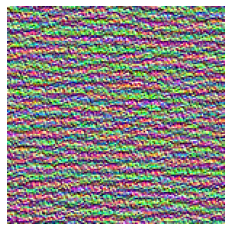

In [31]:
plt.axis("off")
plt.imshow(deprocess_image(generate_filter_pattern(filter_index=2)))

<img src="https://drek4537l1klr.cloudfront.net/chollet2/Figures/09-16.png" width="250"><p style="text-align:center">Figure 9.16 Pattern that the second channel in layer block3_sepconv1 responds to maximally</p>

**Generating a grid of all filter response patterns in a layer**

In [32]:
all_images = []
for filter_index in range(64):
    print(f"Processing filter {filter_index}")
    image = deprocess_image(
        generate_filter_pattern(filter_index)
    )
    all_images.append(image)

margin = 5
n = 8
cropped_width = img_width - 25 * 2
cropped_height = img_height - 25 * 2
width = n * cropped_width + (n - 1) * margin
height = n * cropped_height + (n - 1) * margin
stitched_filters = np.zeros((width, height, 3))

for i in range(n):
    for j in range(n):
        image = all_images[i * n + j]
        stitched_filters[
            (cropped_width + margin) * i : (cropped_width + margin) * i + cropped_width,
            (cropped_height + margin) * j : (cropped_height + margin) * j
            + cropped_height,
            :,
        ] = image

keras.utils.save_img(
    f"filters_for_layer_{layer_name}.png", stitched_filters)

Processing filter 0
Processing filter 1
Processing filter 2
Processing filter 3
Processing filter 4
Processing filter 5
Processing filter 6
Processing filter 7
Processing filter 8
Processing filter 9
Processing filter 10
Processing filter 11
Processing filter 12
Processing filter 13
Processing filter 14
Processing filter 15
Processing filter 16
Processing filter 17
Processing filter 18
Processing filter 19
Processing filter 20
Processing filter 21
Processing filter 22
Processing filter 23
Processing filter 24
Processing filter 25
Processing filter 26
Processing filter 27
Processing filter 28
Processing filter 29
Processing filter 30
Processing filter 31
Processing filter 32
Processing filter 33
Processing filter 34
Processing filter 35
Processing filter 36
Processing filter 37
Processing filter 38
Processing filter 39
Processing filter 40
Processing filter 41
Processing filter 42
Processing filter 43
Processing filter 44
Processing filter 45
Processing filter 46
Processing filter 47
Pr

<img src="https://drek4537l1klr.cloudfront.net/chollet2/Figures/09-17.png" width="500"><p style="text-align:center">Figure 9.17 Some filter patterns for layers block2_sepconv1, block4_sepconv1, and block8_sepconv1</p>

### Visualizing heatmaps of class activation


**Gradient 클래스 활성화 맵(Class Activation Map: grad CAM)** 시각화

입력 이미지에 대한 클래스 활성화 히트맵(heatmap)을 생성

예를 들어 dogs-vs-cats 모델의 경우 히트맵을 생성할 수 있습니다.
* cat (이미지의 고양이 같은 부분)
* dog (이미지의 개 같은 부분)

이 기술은 다음을 가능케 해줍니다.
* 결정 프로세스의 디버깅
* 이미지에서 특정 개체 찾기

작동 방식
* 입력 이미지에 대한 conv 레이어(e.g. 마지막 레이어)의 **출력 특징 맵**을 가져옵니다.
* 채널에 대한 클래스의 그라이언트에 따라 특징 맵의 모든 채널에 가중치 부여

**Loading the Xception network with pretrained weights**

In [31]:
from tensorflow import keras

model = keras.applications.xception.Xception(weights="imagenet")

91897856/91884032 [==============================] - 110s 1us/step


**Preprocessing an input image for Xception**

745472/733657 [==============================] - 1s 2us/step


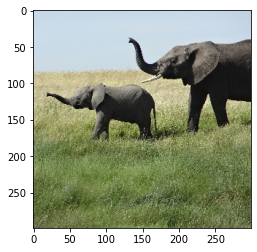

In [32]:
import numpy as np
import matplotlib.pyplot as plt


img_path = keras.utils.get_file(
    fname="elephant.jpg",
    origin="https://img-datasets.s3.amazonaws.com/elephant.jpg")

def get_img_array(img_path, target_size):
    img = keras.preprocessing.image.load_img(img_path, target_size=target_size)
    array = keras.preprocessing.image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    array = keras.applications.xception.preprocess_input(array)
    return array

img_array = get_img_array(img_path, target_size=(299, 299))

plt.imshow(img_array[0]/2 + 0.5)
plt.show()

In [33]:
preds = model.predict(img_array)
print(keras.applications.xception.decode_predictions(preds, top=3)[0])

49152/35363 [=========================================] - 0s 2us/step
[('n02504458', 'African_elephant', 0.8699366), ('n01871265', 'tusker', 0.07696766), ('n02504013', 'Indian_elephant', 0.02353725)]


In [34]:
np.argmax(preds[0])

386

**Setting up a model that returns the last convolutional output**

In [35]:
last_conv_layer_name = "block14_sepconv2_act"
classifier_layer_names = [
    "avg_pool",
    "predictions",
]
last_conv_layer = model.get_layer(last_conv_layer_name)
last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

**Reapplying the classifier on top of the last convolutional output**

In [36]:
classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input
for layer_name in classifier_layer_names:
    x = model.get_layer(layer_name)(x)
classifier_model = keras.Model(classifier_input, x)

**Retrieving the gradients of the top predicted class**

In [37]:
import tensorflow as tf

with tf.GradientTape() as tape:
    last_conv_layer_output = last_conv_layer_model(img_array)
    tape.watch(last_conv_layer_output)
    preds = classifier_model(last_conv_layer_output)
    top_pred_index = tf.argmax(preds[0])
    top_class_channel = preds[:, top_pred_index]

grads = tape.gradient(top_class_channel, last_conv_layer_output)

**Gradient pooling and channel-importance weighting**

In [38]:
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2)).numpy() # shape (2048,)
last_conv_layer_output = last_conv_layer_output.numpy()[0]   # shape (10,10,2048)
for i in range(pooled_grads.shape[-1]):
    last_conv_layer_output[:, :, i] *= pooled_grads[i]
heatmap = np.mean(last_conv_layer_output, axis=-1)  # shape (10,10)

**Heatmap post-processing**

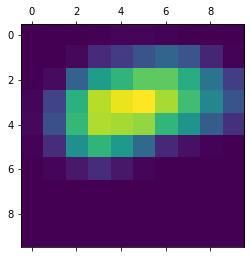

In [39]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

**Superimposing the heatmap on the original picture**

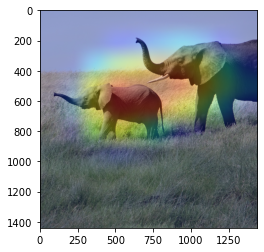

In [40]:
import matplotlib.cm as cm

img = keras.preprocessing.image.load_img(img_path)
img = keras.preprocessing.image.img_to_array(img)

heatmap = np.uint8(255 * heatmap)

jet = cm.get_cmap("jet")
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

superimposed_img = jet_heatmap * 0.4 + img
superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

# save_path = "elephant_cam.jpg"
# superimposed_img.save(save_path)

plt.imshow(superimposed_img)
plt.show()

## Summary

* 딥러닝으로 할 수 있는 세 가지 필수 컴퓨터 비전 작업이 있습니다.
   * 이미지 분류
   * 이미지 분할
   * 물체 감지
* 모범 사례들은 모델을 최대한 활용하는 데 도움이 됩니다.
   * residual connections
   * 배치 정규화(batch normalization)
   * 깊이별 분리 가능한 컨볼루션(depthwise separable convolutions)
* convnet이 학습하는 표현은 검사하기 쉽습니다(블랙박스 아님)
* 클래스별 활성화의 히트맵(heatmaps of class activity) 생성 가능